## Table of Contents

1. [Problem Statement](#section1)<br>
2. [Importing Packages](#section2)<br>
3. [Loading Data](#section3)
4. [Data Preprocessing](#section4)<br>
  - 4.1 [Fixing datatypes of columns](#section401)<br>
  - 4.2 [Filtering common device id across data](#section402)<br>
  - 4.3 [Categorising 'age' column](#section403)<br>
  - 4.4 [Translate phone_brand](#section404)<br>
  - 4.5 [Extract day, hour, month](#section405)<br>
  - 4.6 [Merge all dataframes together](#section406)<br>
  - 4.7 [Impute missing values](#section407)<br>
5. [Exploratory Data Analysis](#section5)<br>
  - 5.1 [Phone usage across device model](#section501)<br>
  - 5.2 [Phone usage across geography](#section502)<br>
  - 5.3 [Phone usage across gender](#section503)<br>
  - 5.4 [Phone usage v/s time](#section504)<br>
  - 5.5 [Phone usage over age range](#section505)<br>
  - 5.6 [Phone usage over phone brand](#section506)<br>
6. [Actionable Insights](#section6)<br>
  


<a id=section1></a>
# 1. Problem Statement

**InsaidTelecom**, one of the leading telecom players, understands that customizing offering
is very important for its business to stay competitive.
Currently, InsaidTelecom is seeking to leverage behavioral data from more than 60% of the 50 million mobile devices active daily in India
to help its clients better understand and interact with their audiences.

**Business Goal :**

To help the customer the consultants are expected to have depth of clarity in the underlying data.
How much effort has been put into cleansing and purifying the data will decide how closely have you looked at the data.
How detailed is the observation stated in the submission report and finally how well a group presents their consulting journey.

Please remember this is an analytics consulting hence, your efforts in terms of
finding user behavior is going to directly impact the company's offerings.
Do help the company understand what is the
right way forward and suggest actionable insights from marketing and product terms.

<a id=section2></a>
# 2. Importing Packages

In [1]:
import numpy as np                     

import pandas as pd

# To suppress pandas warnings.
pd.set_option('mode.chained_assignment', None) 

# To display all the data in each column
pd.set_option('display.max_colwidth', -1)         

pd.get_option("display.max_rows",10000)

# To display every column of the dataset in head()
pd.options.display.max_columns = 100               

import warnings
warnings.filterwarnings('ignore')     

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# To apply seaborn styles to the plots.
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)      

<a id=section3></a>

# 3. Loading Data

In [ ]:
#!pip install mysql.connector

In [ ]:
import mysql.connector as sql

db_connection = sql.connect(host='cpanel.insaid.co', database='Capstone1', user='student', password='student', connect_timeout=10000 )

In [ ]:
# load gender_age_train
gender_age_train = pd.read_sql('SELECT * FROM gender_age_train', con=db_connection)
gender_age_train.to_csv('gender_age_train.csv')
gender_age_train.info()

In [ ]:
# load phone_brand_device_model
phone_brand_device_model = pd.read_sql('SELECT * FROM phone_brand_device_model', con=db_connection)
phone_brand_device_model.to_csv('phone_brand_device_model.csv')
phone_brand_device_model.info()

In [ ]:
# load events_data
events_data = pd.read_csv('event_data.csv')

events_data.info()

<a id=section4></a>
# 4. Data Preprocessing

In [ ]:
gender_age_train = pd.read_csv('gender_age_train.csv')
phone_brand_device_model = pd.read_csv('phone_brand_device_model.csv')

<a id=section401></a>
## 4.1 Fixing datatypes of columns

In [ ]:
# converting device_id and event_id to string
gender_age_train['device_id'] = gender_age_train['device_id'].apply(lambda id : f'{id:.0f}')
phone_brand_device_model['device_id'] = phone_brand_device_model['device_id'].apply(lambda id : f'{id:.0f}')
events_data['event_id'] = events_data['event_id'].astype(int).astype(str)
events_data['device_id'] = events_data['device_id'].apply(lambda id : f'{id:.0f}')

In [ ]:
# converting timestamp to pandas datetime
try:
  events_data['timestamp'] = pd.to_datetime(events_data['timestamp'])
except ValueError as e:
  pass
events_data.info()

<a id=section402></a>
## 4.2 Filtering common device id across data

In [ ]:
unique_device_ids_events = set(events_data['device_id'])

In [ ]:
unique_device_ids_phone_brands = set(phone_brand_device_model['device_id'])

In [ ]:
unique_device_ids_gender_age = set(gender_age_train['device_id'])

In [ ]:
common_device_ids = unique_device_ids_events.intersection(unique_device_ids_phone_brands)
common_device_ids = common_device_ids.intersection(unique_device_ids_gender_age)
len(common_device_ids)

**NOTE :**

We have **44716** unique device_ids. let's take only data of these device_ids into consideration.

In [ ]:
gender_age_train = gender_age_train[gender_age_train['device_id'].isin(common_device_ids)]
gender_age_train.shape

In [ ]:
phone_brand_device_model = phone_brand_device_model[phone_brand_device_model['device_id'].isin(common_device_ids)]
phone_brand_device_model.shape

In [ ]:
events_data = events_data[events_data['device_id'].isin(common_device_ids)]
events_data.shape

<a id=section403></a>
## 4.3 Categorising 'age' column

In [ ]:
# categorising age to bins of age range and dropping group and age columns
gender_age_train["age_bin"] = pd.cut(gender_age_train['age'], [0, 17, 29,49,64,500], labels=['<18','18-29','30-49','50-64','65+'], include_lowest=True)
gender_age_train["age_bin"]

In [ ]:
gender_age_train.drop(['group', 'age' ], axis=1, inplace=True)

In [ ]:
gender_age_train.to_csv("gender_age_train_cleaned.csv")

<a id=section404></a>
## 4.4 Translate phone_brand


In [ ]:
phone_brand_map = {
    '华为':	'Huawei',
    '小米':	'Xiaomi',
    '三星':	'Samsung',
    'vivo':	'vivo',
    'OPPO':	'OPPO',
    '魅族':	'Meizu',
    '酷派':	'Coolpad',
    '乐视':	'LeEco',
    '联想 ': 'Lenovo',
    'HTC':	'HTC'
}

In [ ]:
def map_phone_brands(brand):
  if phone_brand_map.get(brand) is None:
    return 'others'
  else:
    return phone_brand_map.get(brand)

In [ ]:
phone_brand_device_model['phone_brand'] = phone_brand_device_model['phone_brand'].apply(map_phone_brands)
phone_brand_device_model.info()

In [ ]:
phone_brand_device_model.to_csv("phone_brand_device_model_cleaned.csv")

<a id=section405></a>
## 4.5 Extract day, hour, month

In [ ]:
events_data['hour_of_day'] = events_data['timestamp'].dt.hour
events_data['day_of_month'] = events_data['timestamp'].dt.day
events_data['month'] = events_data['timestamp'].apply(lambda time: time.strftime("%B"))
events_data['day_of_week'] = events_data['timestamp'].dt.weekday
events_data['year'] = events_data['timestamp'].dt.year

day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
events_data['day_of_week'] = events_data['day_of_week'].map(day_of_week_map)

In [ ]:
events_data.sample(10)

<a id=section406></a>
## 4.6 Merge all dataframes together

In [ ]:
phone_data = pd.merge(events_data, phone_brand_device_model, on='device_id', how='left')
print(phone_data.shape)
phone_data = pd.merge(phone_data, gender_age_train, on='device_id', how='left')
print(phone_data.shape)

<a id=section407></a>
## 4.7 Impute missing values

In [ ]:
phone_data.isna().sum()

In [ ]:
cities = list(phone_data['city'].unique())

In [ ]:
city_state_map = {}
for city in cities:
  try:
    city_state_map[city] = phone_data[phone_data['city'] == city]['state'].mode()[0]
  except (KeyError, IndexError) :
    pass

In [ ]:
nan_rows = phone_data[phone_data['state'].isna()]
nan_indexes = list(nan_rows.index)

for i in nan_indexes:
  try:
    phone_data['state'][i] = city_state_map[phone_data['city'][i]]
  except KeyError:
    pass

In [ ]:
phone_data.isna().sum()

In [ ]:
def getLong(row):
    long = row['longitude']
    city = row['city']
   
    if (pd.notnull(city) and ((long =='') or (pd.isnull(long)))):
        print(row['device_id'])
        longM = phone_data['longitude'][(phone_data['city'] == city) & (pd.notnull(phone_data['longitude']))].mode()[0]
        return longM
    else:
        return long

In [ ]:
def getLat(row):
    lat = row['latitude']
    city = row['city']
   
    if (pd.notnull(city) and ((lat =='') or (pd.isnull(lat)))):
        print(row['device_id'])
        LatM = phone_data['latitude'][(phone_data['city'] == city) & (pd.notnull(phone_data['latitude']))].mode()[0]
        return LatM
    else:
        return lat

In [ ]:
phone_data['latitude'] = phone_data.apply(getLat, axis=1)
phone_data['longitude'] = phone_data.apply(getLong, axis=1)

In [ ]:
phone_data.isna().sum()

In [ ]:
phone_data.columns

In [ ]:
phone_data.drop(['Unnamed: 0_x', 'Unnamed: 0_y', ''], axis=1, inplace=True)

In [ ]:
events_data_sanitized = phone_data[['event_id','device_id','timestamp','longitude','latitude','state']].sample(200000)
events_data_sanitized.set_index('event_id', inplace=True)
events_data_sanitized.to_csv('events_data_sanitized.csv')

In [ ]:
phone_data.drop(['timestamp'], axis=1, inplace=True)
phone_data.to_csv('phone_data.csv')

In [3]:
phone_data = pd.read_csv('phone_data.csv', index_col = 'event_id')
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2413281 entries, 1 to 3251669
Data columns (total 14 columns):
device_id       int64
longitude       float64
latitude        float64
city            object
state           object
hour_of_day     int64
day_of_month    int64
month           object
day_of_week     object
year            int64
phone_brand     object
device_model    object
gender          object
age_bin         object
dtypes: float64(2), int64(4), object(8)
memory usage: 276.2+ MB


In [4]:
phone_data.sample(20)

,device_id,longitude,latitude,city,state,hour_of_day,day_of_month,month,day_of_week,year,phone_brand,device_model,gender,age_bin
event_id,,,,,,,,,,,,,,
647343,4697355355223944192,83.371534,17.803535,Visakhapatnam,AndhraPradesh,22,1,May,Sunday,2016,Xiaomi,红米1S,M,30-49
1279996,-2611733232907371520,77.239226,28.740743,Delhi,Delhi,11,2,May,Monday,2016,Samsung,Galaxy S6,F,30-49
1303362,-5915714223069442048,80.361626,13.131306,Chennai,TamilNadu,3,7,May,Saturday,2016,Lenovo,V5 Max,M,18-29
593920,40228966137823312,73.877475,18.627749,Pune,Maharashtra,3,1,May,Sunday,2016,Samsung,G3588V,M,18-29
2097685,4100499219285606400,77.300610,28.724472,Delhi,Delhi,15,3,May,Tuesday,2016,Samsung,Galaxy Note 4,M,18-29
899551,-1686831655040141568,78.063194,10.453748,Dindigul,TamilNadu,11,1,May,Sunday,2016,Xiaomi,MI 4,M,30-49
1714499,-8667343479348166656,74.316101,29.668652,Hanumangarh,Rajasthan,11,6,May,Friday,2016,Xiaomi,红米1S,M,18-29
406787,-677983530989321728,77.222759,28.766862,Delhi,Delhi,8,2,May,Monday,2016,Huawei,Ascend P8,F,30-49
1977154,-7752590298681593856,83.310518,17.784964,Visakhapatnam,AndhraPradesh,20,2,May,Monday,2016,HTC,Desire 820,M,18-29


<a id=section5></a>
# 5. Exploratory Data Analysis

<a id=section501></a>
## 5.1 Phone usage across device model

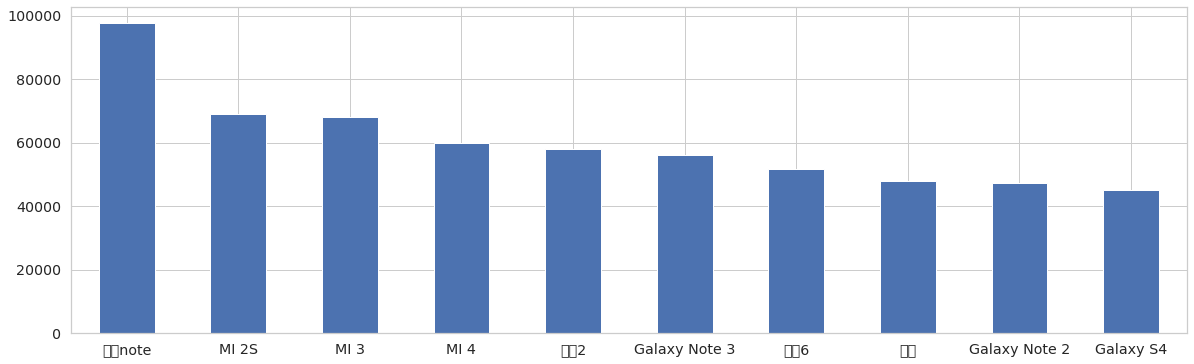

In [5]:
phone_data_across_device_model= phone_data['device_model'].value_counts().head(10)
phone_data_across_device_model.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**

We can observe **note series** ad **MI series** are most used device models.

<a id=section502></a>
## 5.2 Phone usage across geography

<a id=section50201></a>
### 5.2.1 Phone usage across cities

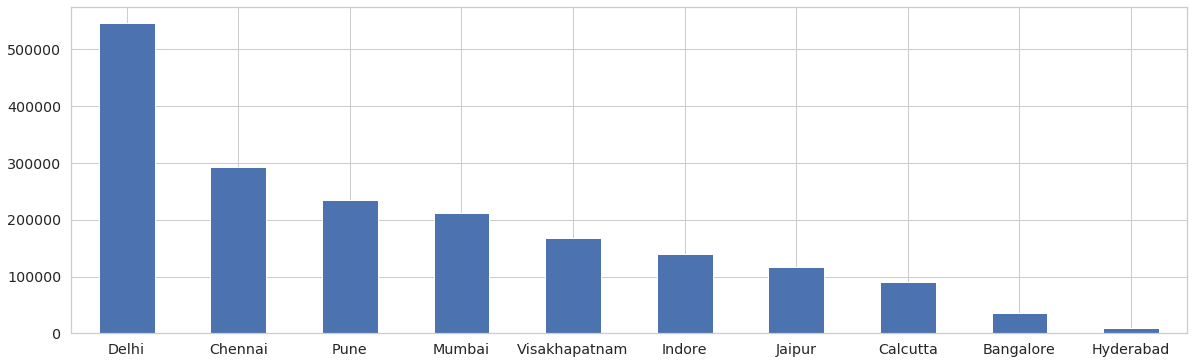

In [7]:
phone_data_across_cities = phone_data['city'].value_counts().head(10)
phone_data_across_cities.plot.bar(rot=0,figsize=(20, 6))

<a id=section50202></a>
### 5.2.2 Phone usage across states

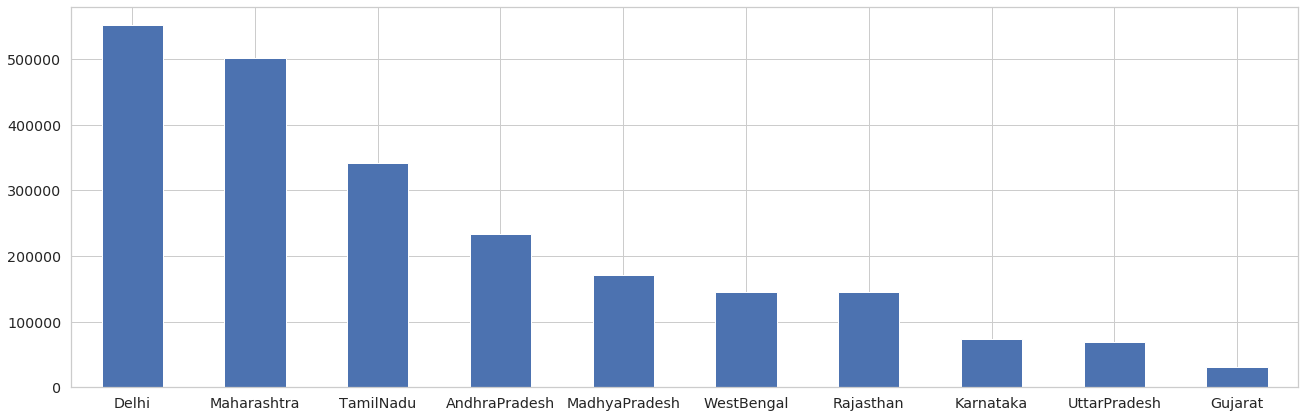

In [8]:
phone_data_across_states = phone_data['state'].value_counts().head(10)
phone_data_across_states.plot.bar(rot=0,figsize=(22, 7))

<a id=section50203></a>
### 5.2.3 Phone usage across latitude and longitude

In [ ]:
lat_long = phone_data[['latitude', 'longitude']]
lat_long.drop_duplicates(inplace=True)

In [ ]:
locations = lat_long
locationlist = locations.values.tolist()

In [ ]:
import folium
map = folium.Map(location=[20.5937, 78.9629], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(map)
for point in range(0, len(locationlist)):
    try:
        folium.Marker(locationlist[point], popup=phone_data['city'][point], 
                  icon=folium.Icon(color='darkblue', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)
    except:
        pass

map.save('phone_usage.html')

<img src="phone_data_distribution.png" height='400px' width='100%'><br/>

**NOTE :**

As expected, most of the phone usage is in metropolitan cities and capital cities.

<a id=section503></a>
## 5.3 Phone usage across gender

<a id=section50301></a>
### 5.3.1  Overall

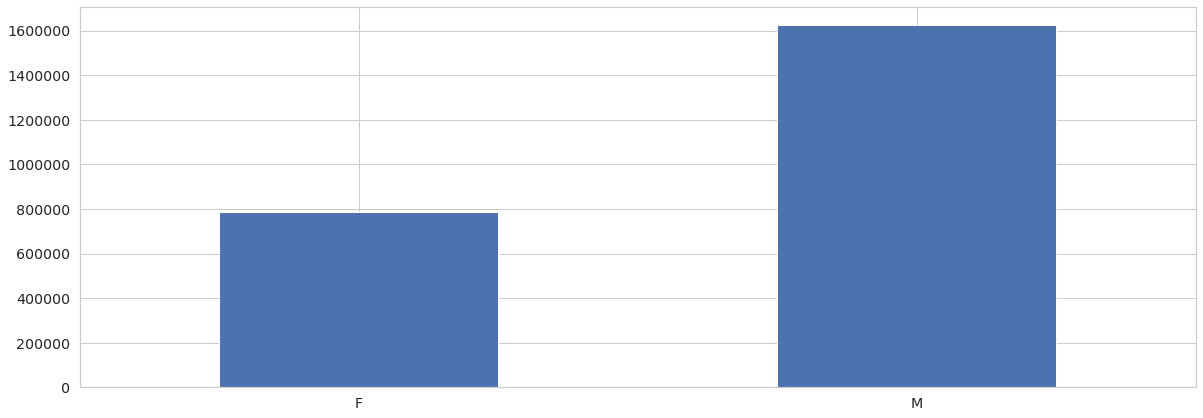

In [9]:
phone_data_across_gender = phone_data['gender'].value_counts(sort=False)
phone_data_across_gender.plot.bar(rot=0,figsize=(20, 7))

**NOTE :**

We can see there is definitely data imbalance in gender. Any analysis based on gender will be biased towards one gender. Let's run few queries and confirm my hypothesis.

<a id=section50302></a>
### 5.3.2  Phone brand usage over gender

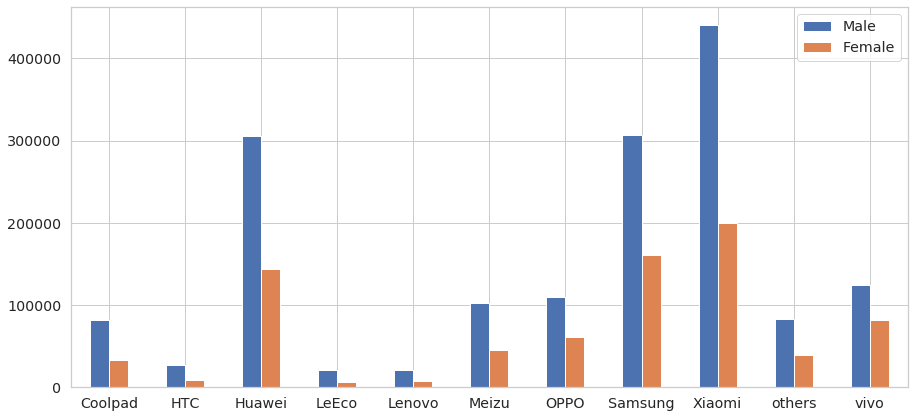

In [10]:
df = pd.DataFrame(
	{
	'Male': phone_data[phone_data['gender'] == 'M']['phone_brand'].value_counts(sort=False),
    'Female': phone_data[phone_data['gender'] == 'F']['phone_brand'].value_counts(sort=False)
	})
df.plot.bar(rot=0,figsize=(15, 7))

<a id=section50303></a>
### 5.3.3  Daily usage gender wise

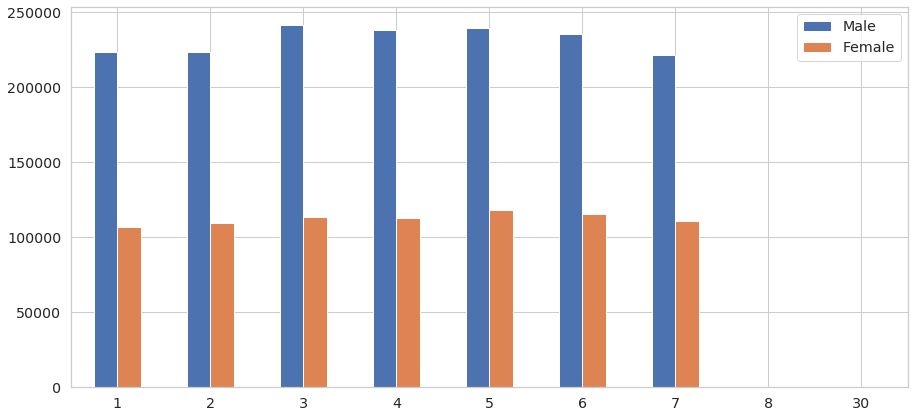

In [11]:
df = pd.DataFrame(
	{
	'Male': phone_data[phone_data['gender'] == 'M']['day_of_month'].value_counts(sort=False),
    'Female': phone_data[phone_data['gender'] == 'F']['day_of_month'].value_counts(sort=False)
	})
df.plot.bar(rot=0,figsize=(15, 7))

<a id=section50304></a>
### 5.3.4  Phone usage over day of week gender wise


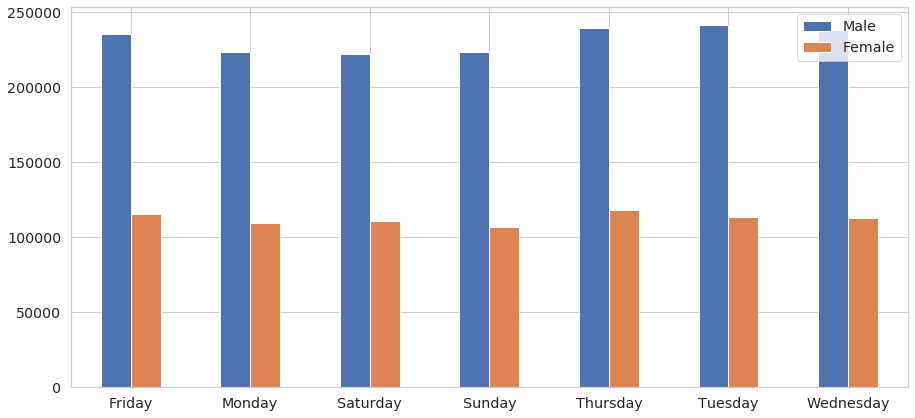

In [12]:
df = pd.DataFrame(
	{
	'Male': phone_data[phone_data['gender'] == 'M']['day_of_week'].value_counts(sort=False),
    'Female': phone_data[phone_data['gender'] == 'F']['day_of_week'].value_counts(sort=False)
	})
df.plot.bar(rot=0,figsize=(15, 7))

<a id=section50305></a>
### 5.3.5 Hourly usage gender wise

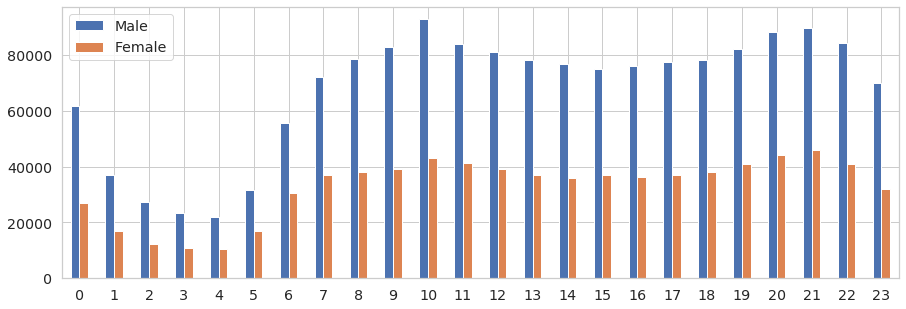

In [13]:
df = pd.DataFrame(
	{
	'Male': phone_data[phone_data['gender'] == 'M']['hour_of_day'].value_counts(sort=False),
    'Female': phone_data[phone_data['gender'] == 'F']['hour_of_day'].value_counts(sort=False)
	})
df.plot.bar(rot=0,figsize=(15, 5))

**NOTE :**

We can observe disregarding criteria,analysis is biased towards one gender. We can't get any actionable insights here.

<a id=section504></a>
## 5.4 Phone usage v/s time


<a id=section50401></a>
### 5.4.1 Phone usage over hour of day

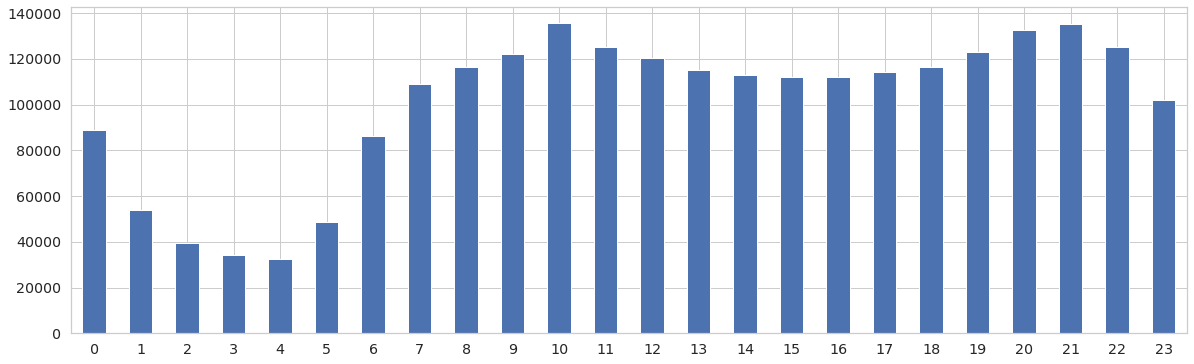

In [14]:
phone_data_across_hour_of_day = phone_data['hour_of_day'].value_counts(sort=False)

phone_data_across_hour_of_day.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**

We observe phone usage is low between **1:00 am to 5:00 am**.

<a id=section50402></a>
### 5.4.2 Phone usage over day of month

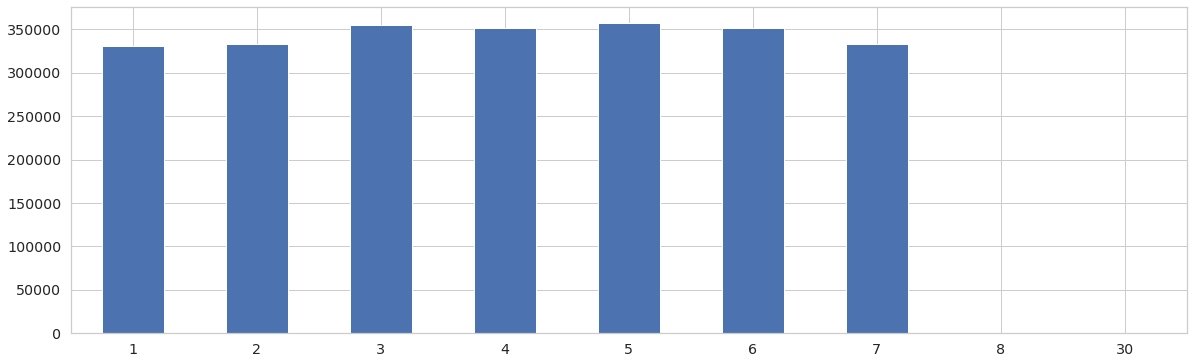

In [15]:
phone_data_across_day_of_month = phone_data['day_of_month'].value_counts(sort=False)
phone_data_across_day_of_month.plot.bar(rot=0,figsize=(20, 6))

<a id=section50403></a>
### 5.4.3 Phone usage over day of week

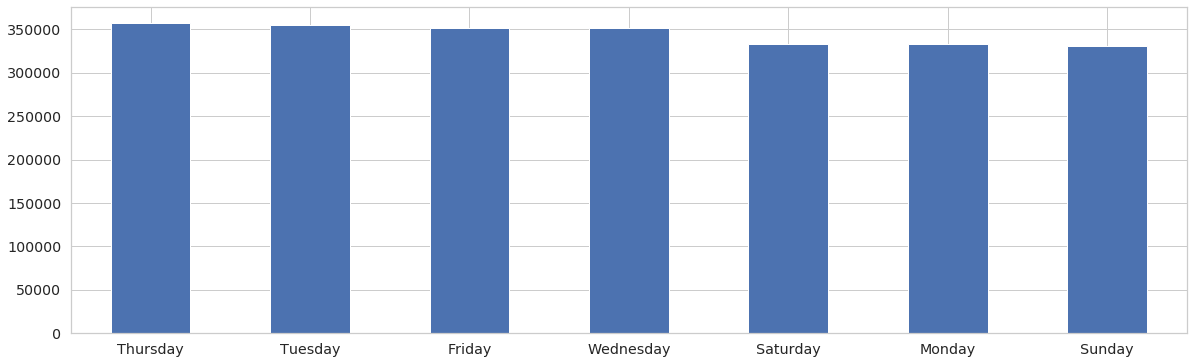

In [16]:
phone_data_across_day_of_week = phone_data['day_of_week'].value_counts(sort=True)

phone_data_across_day_of_week.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**


<a id=section50404></a>
### 5.4.4 Phone usage over month

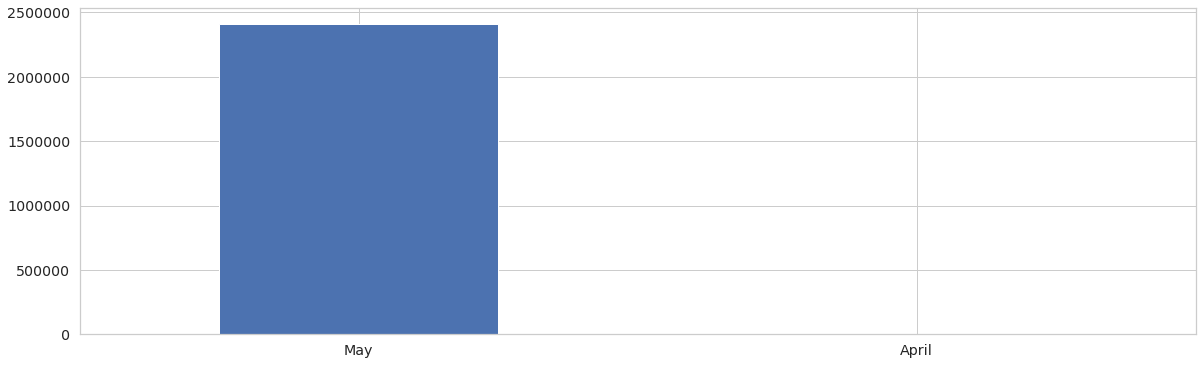

In [18]:
phone_data_across_month = phone_data['month'].value_counts(sort=False)

phone_data_across_month.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**

**month** has only only two unique values . So, lets drop it. 

<a id=section50405></a>
### 5.4.5 Phone usage over year

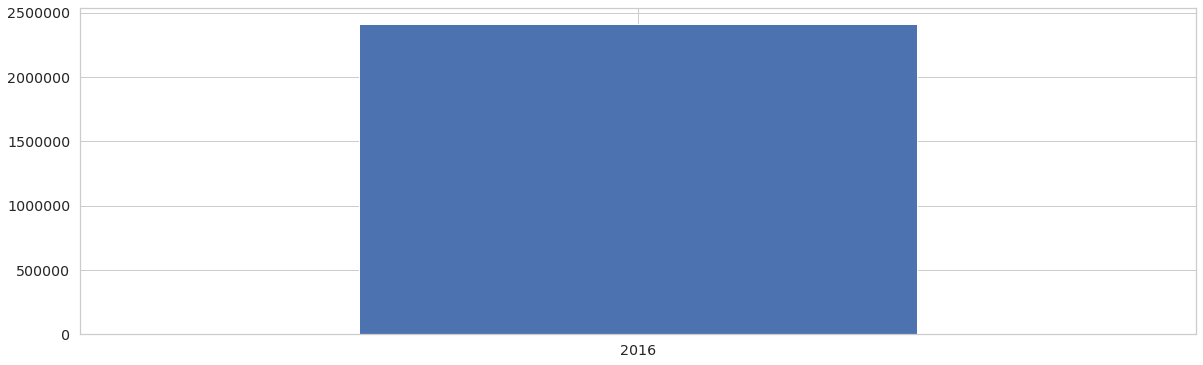

In [19]:
phone_data_across_year = phone_data['year'].value_counts(sort=False)

phone_data_across_year.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**

**year** has only only one unique value . So, lets drop it. 

In [20]:
# dropping year and month column
phone_data.drop(['year','month'],axis=1, inplace=True)

<a id=section505></a>
## 5.5 Phone usage over age range

<a id=section50501></a>

### 5.5.1 Phone usage overall

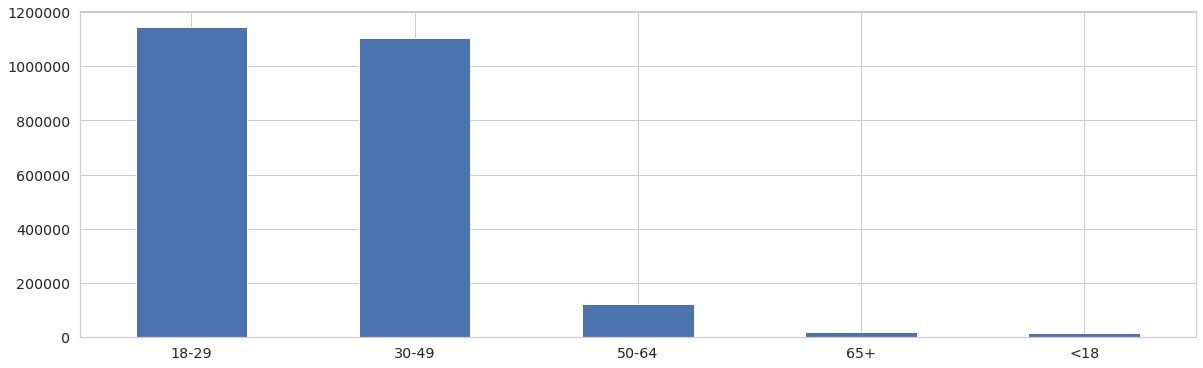

In [28]:
phone_data_across_age_range = phone_data['age_bin'].value_counts()
phone_data_across_age_range.plot.bar(rot=0,figsize=(20, 6))

**NOTE :**

No surprises!! 18-49 is age group who use mobile a lot.

<a id=section50502></a>

### 5.5.2 Which age group prefer which brand?


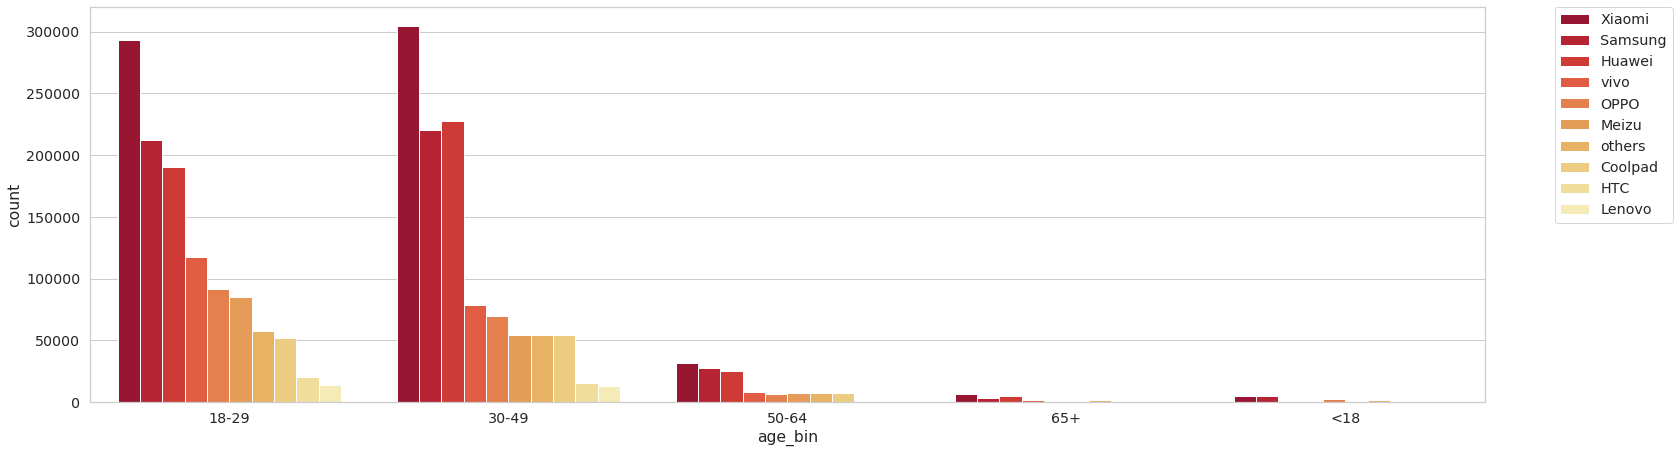

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 7.27)
sns.countplot(x='age_bin',data=phone_data,hue='phone_brand',palette='YlOrRd_r', 
              order=phone_data['age_bin'].value_counts().iloc[0:10].index, 
              hue_order=phone_data['phone_brand'].value_counts().iloc[:10].index)

# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**NOTE :**

Almost all age groups prefer **XIOMI**

<a id=section50503></a>

### 5.5.3 Phone usage across age group(state-wise)


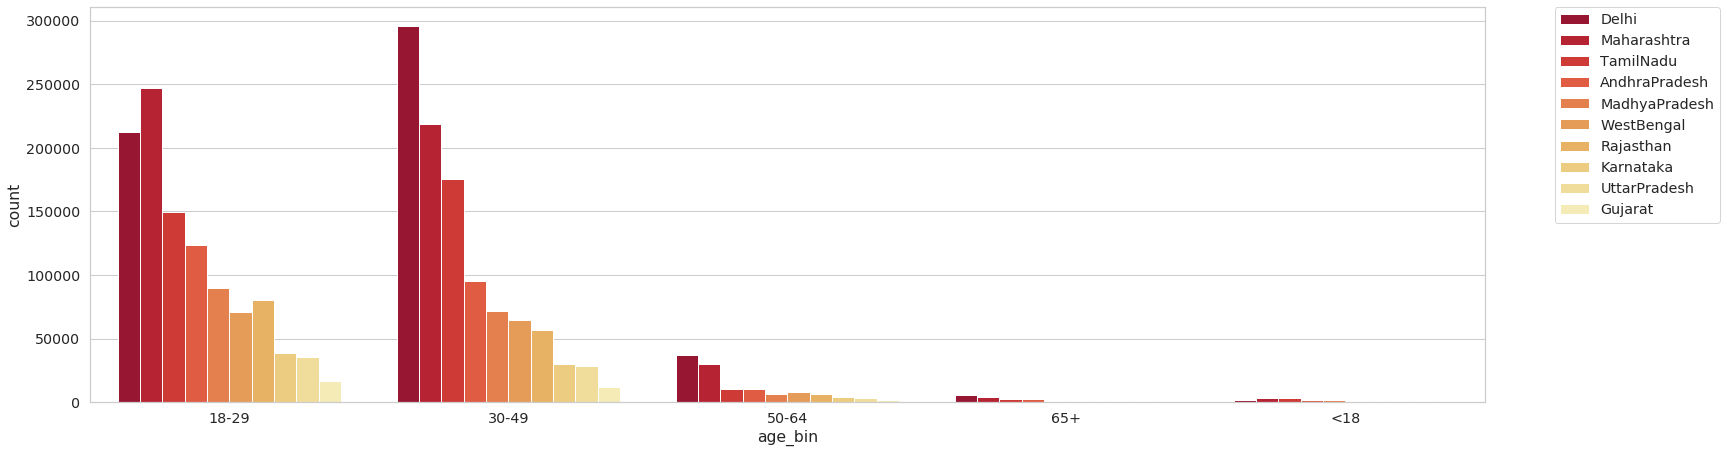

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 7.27)
sns.countplot(x='age_bin',data=phone_data,hue='state',palette='YlOrRd_r', 
              order=phone_data['age_bin'].value_counts().iloc[0:10].index, 
              hue_order=phone_data['state'].value_counts().iloc[:10].index)

# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**NOTE :**

Apart from age-group 18-29, Delhi has most number of mobile users.

<a id=section50505></a>

### 5.5.5 Phone usage across age group(day of week-wise)


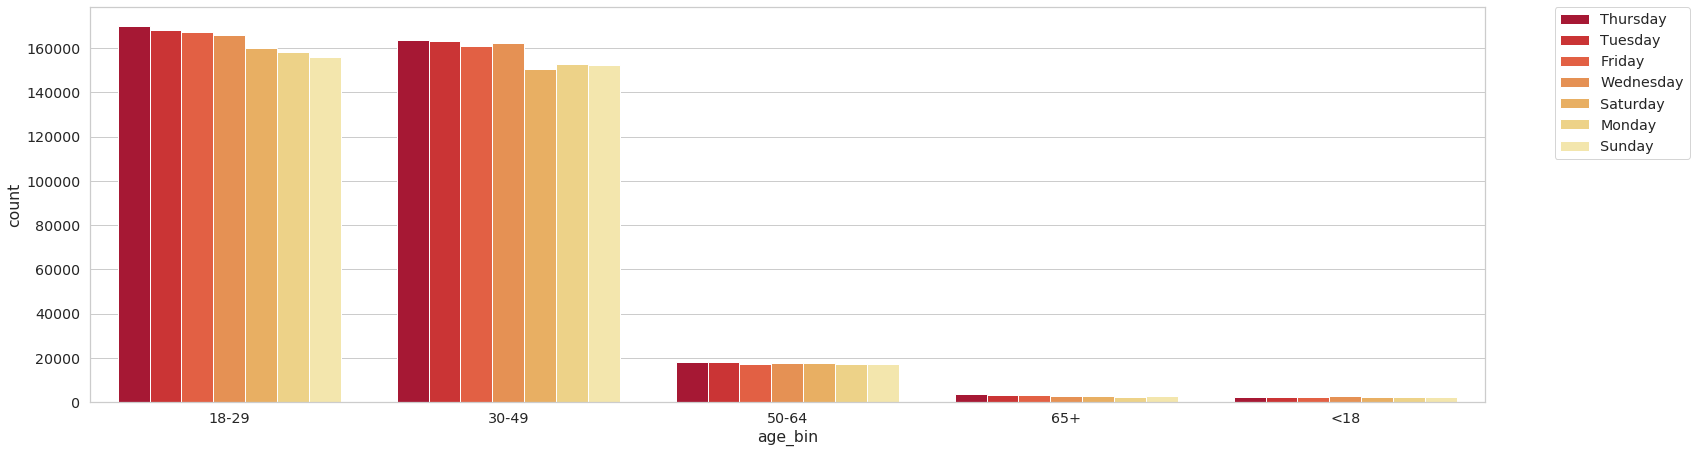

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 7.27)
sns.countplot(x='age_bin',data=phone_data,hue='day_of_week',palette='YlOrRd_r', 
              order=phone_data['age_bin'].value_counts().iloc[0:10].index, 
              hue_order=phone_data['day_of_week'].value_counts().iloc[:10].index)

# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<a id=section50506></a>

### 5.5.6 Phone usage across age group(hour of day-wise)


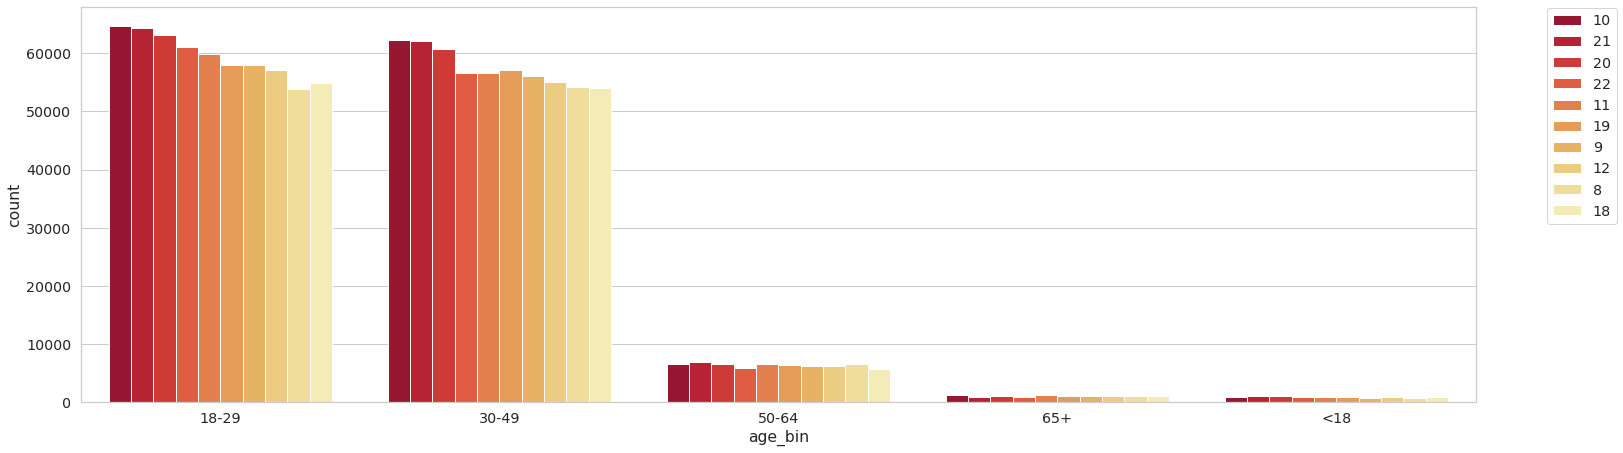

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 7.27)
sns.countplot(x='age_bin',data=phone_data,hue='hour_of_day',palette='YlOrRd_r', 
              order=phone_data['age_bin'].value_counts().iloc[0:10].index, 
              hue_order=phone_data['hour_of_day'].value_counts().iloc[:10].index)

# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

<a id=section506></a>

## 5.6 Phone usage over phone brand

<a id=section50601></a>

### 5.6.1 Overall

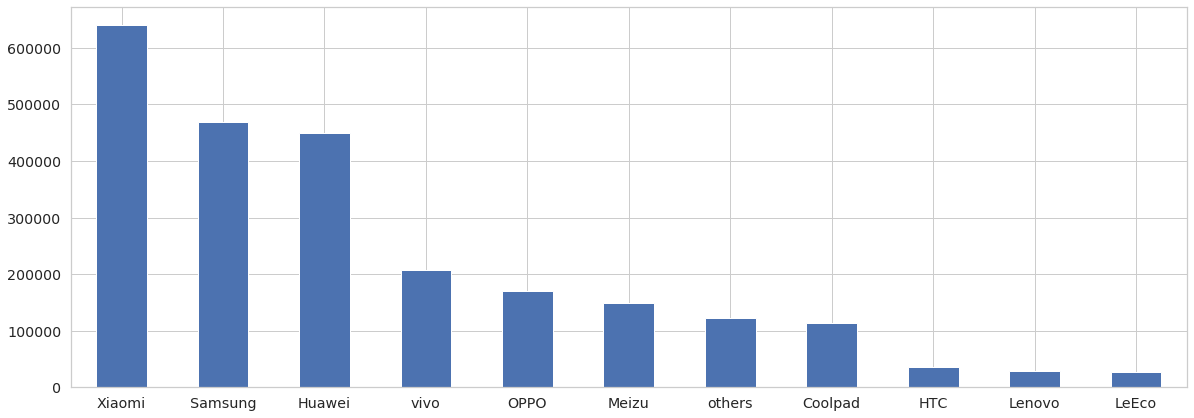

In [26]:
phone_data_across_phone_brand = phone_data['phone_brand'].value_counts()
phone_data_across_phone_brand.plot.bar(rot=0,figsize=(20, 7))

<a id=section50602></a>

### 5.6.2 Phone brand usage over city

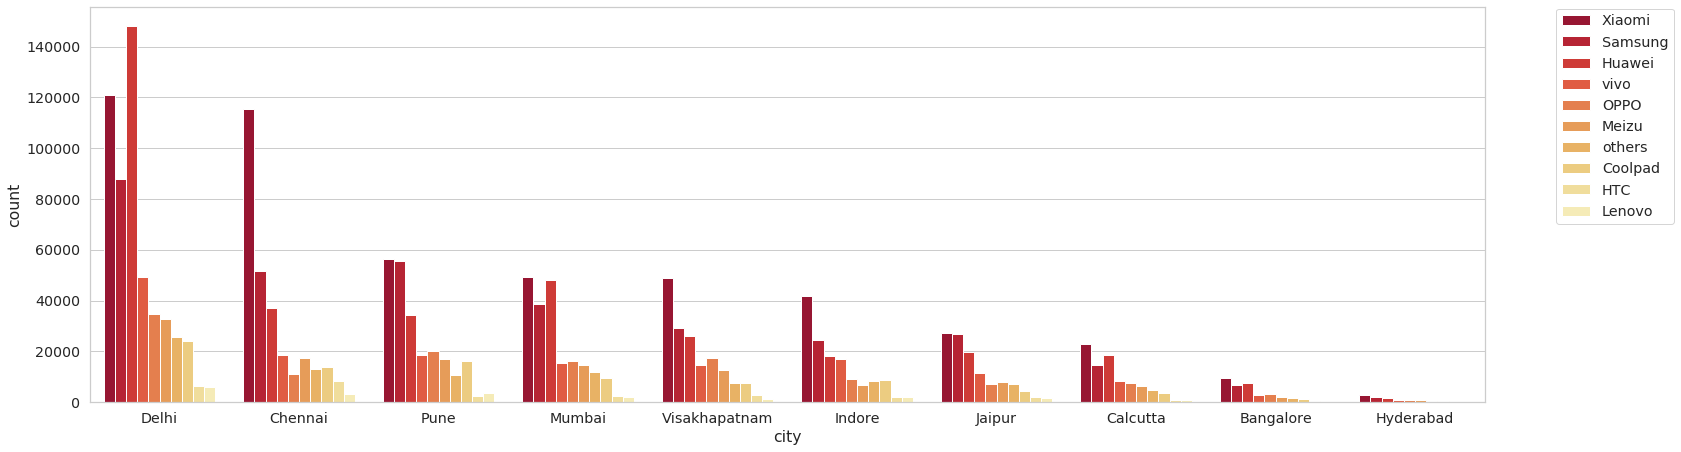

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 7.27)
sns.countplot(x='city',data=phone_data,hue='phone_brand',palette='YlOrRd_r', 
              order=phone_data['city'].value_counts().iloc[0:10].index, 
              hue_order=phone_data['phone_brand'].value_counts().iloc[:10].index)

# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

**NOTE :**

Except Delhi, **XIOMI** is most used phone brand in all cities.

<a id=section6></a>
# 6. Actionable Insights

1. As there is very low phone usage during 1:00 am to 5:00 am, companies can come up with new plans to engage people during that period.

2. Phone usage in age group >50 years, is low. Companies can work on phone design which is easy to use for any age-group.

3. Companies should work on its brand in small cities.

4. Phone usage on week ends, is low when compared to week days. May be most people use phone for official use. Companies can come up with plans to use this observation to grab more profits. 